# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the data set we'll be using is avaiable here https://arxiv.org/abs/1710.06071)

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-63df1804-cbfb-0fb1-8951-acc8ca538d5d)


## Get data

Since we'll be replicating the paper above (PubMed 200K RCT), let's download the dataset they used.

We can do so from the authors GitHub. https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check wat files are in the PubMed_20K_dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20K dataset with numbers replaced by "@" 
data_dir  = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind let's write a function to read in all of the lines of a target text file.

In [6]:
# Create a function to read the lines of a document

def get_lines(filename):
    '''
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string contianing the target filepath

    Returns:
        A list of strings with one string per line from the target filename.
    '''
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+'train.txt') # read the lines within the training file

Let's think about how we wnat our data to look...

How I think our data would be best represented... 

```
[{'line_number': 0,
    'target':  'BACKGROUND',
    'text':  <TEXT>,
    'total_lines': 11},
    ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictonaries of abstact line data.

    Takes in filename, read it contents and sorts through each line,
    extracting things like the target label, the text of senteces,
    how many sentences are in the current abstract and what sentence number the target
    is
    '''
    input_lines = get_lines(filename) #get all lines from filename
    abstract_lines = '' #create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): #check to see if the string is an ID line
            abstract_id = line
            abstract_lines = '' # reset the abstract string if the line is an ID line

        elif line.isspace(): # check to se if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separte lines

            # iterate them through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create emtpy dict for each line
                target_text_split = abstract_line.split('\t') #split target label from text
                
                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number #what number line does the line appear in our abstract
                line_data['total_lines'] = len(abstract_line_split)-1 # How many total lines are in the target abstract (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fullfilled, the line contains a labelled sentece
            abstract_lines += line
    return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'/train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'/dev.txt') #dev is another way to call it
test_samples = preprocess_text_with_line_numbers(data_dir+'/test.txt') 
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 558 ms, sys: 112 ms, total: 670 ms
Wall time: 670 ms


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictonaries, how about we run it inot a DataFrame to further visualize it

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

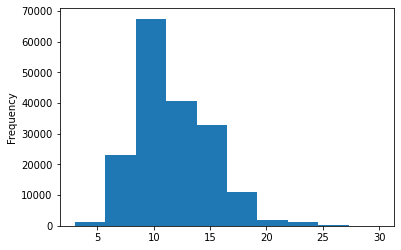

In [13]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [14]:
# Convert abstract text lines into lists

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models requiere numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # We want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform((val_df['target']).to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform((test_df['target']).to_numpy().reshape(-1, 1))

# Check what one got encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive BAyes classifier).

## Model 0: Getting a baseline 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
In the previous module we wrote a function to compare predictions across different metrics (accuracy, preicison, recall and f1) and rather than rewriting here, let's download it from  our helper functions git

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-20 02:23:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-20 02:23:44 (54.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start bulding deeper models, we've got to create vectorization an embedding layers

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

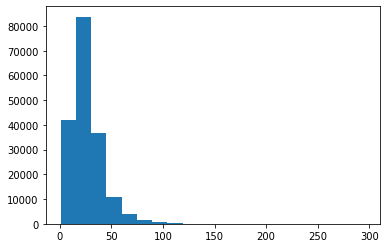

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [28]:
# How long of a sentences lenght covers 95% of examples?
output_seq_len = int(np.quantile(sent_lens, 0.95))
output_seq_len

55

In [29]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to number

In [30]:
# How many words are in our vocab? (taken from table 2 in paper)
max_tokens = 68000

# Create text vectorizer
text_vectorizer =   layers.TextVectorization(max_tokens= max_tokens, # number of words in vocabulary
                                            output_sequence_length = output_seq_len, # desired output lenght
                                             )

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
 at two weeks , the accelerated group initiated wrist/forearm passive range of motion and strengthening exercises , whereas the standard group initiated passive range of motion and strengthening at six weeks postoperatively .

Length of text: 33

Vectorized text: [[   15    51    53     2  3252    13  2137 41768  2241   283     4  1322
      3  4136  1111   436     2   165    13  2137  2241   283     4  1322
      3  4136    15   356    53   721     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create customtext embedding 

In [35]:
# Create token emebedding
token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim = 128, # Note different embedding sizes results in drastically different numbers of params
                                   mask_zero = True, # use masking to handle variables sequences lengths(save space)
                                   name = 'token_embedding'
                                   )

In [36]:
# show example embedding
print(f'Sentence before vectorization: \n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}\n')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}\n')
print(f'Embedded sentence shape: \n {embedded_sentence.shape}\n')

Sentence before vectorization: 
 at two weeks , the accelerated group initiated wrist/forearm passive range of motion and strengthening exercises , whereas the standard group initiated passive range of motion and strengthening at six weeks postoperatively .

Sentence after vectorization: 
 [[   15    51    53     2  3252    13  2137 41768  2241   283     4  1322
      3  4136  1111   436     2   165    13  2137  2241   283     4  1322
      3  4136    15   356    53   721     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[ 0.04949117 -0.03016916  0.04363428 ...  0.04730261 -0.02594867
   -0.01772605]
  [ 0.0438489   0.00088765 -0.03333392 ...  0.0423533  -0.03733715
   -0.03153791]
  [ 0.04993869  0.01450094  0.03026697 ... -0.0082496  -0.04043053
    0.02982017]
  ...
  [-0.04280632 -0.01759912 -0.00356656 ...  0.02076245 -0.02138161
    0.02463367]


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the Tensorflow tf.data.API 


In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1d with token embeddings

In [39]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embed = token_embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embed)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [40]:
# Fit the model
history_model_1  = model_1.fit(train_dataset,
                               epochs = 3,
                               steps_per_epoch = int(0.1*len(train_dataset)),
                               validation_data = valid_dataset,
                               validation_steps = int(0.1*len(valid_dataset)) # only validate on 10% of batches
                               )

Epoch 1/3
562/562 [==============================] - 37s 14ms/step - loss: 0.9111 - accuracy: 0.6405 - val_loss: 0.6898 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6652 - accuracy: 0.7522 - val_loss: 0.6401 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6233 - accuracy: 0.7707 - val_loss: 0.6009 - val_accuracy: 0.7816


In [41]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6035 - accuracy: 0.7855


[0.6034635901451111, 0.7855488061904907]

In [42]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.49068606e-01, 1.73953205e-01, 7.49754533e-02, 2.71624088e-01,
         3.03787142e-02],
        [4.02880162e-01, 3.30133975e-01, 1.40139805e-02, 2.44678989e-01,
         8.29289760e-03],
        [1.72702357e-01, 9.26395226e-03, 3.09436489e-03, 8.14896703e-01,
         4.25501566e-05],
        ...,
        [8.24419931e-06, 1.21502369e-03, 9.13355034e-04, 2.49628056e-06,
         9.97860849e-01],
        [5.45918643e-02, 4.97471839e-01, 8.47485736e-02, 6.44620806e-02,
         2.98725605e-01],
        [1.82288080e-01, 6.20173514e-01, 4.95321639e-02, 7.89793134e-02,
         6.90268353e-02]], dtype=float32), (30212, 5))

In [43]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.55487885608368,
 'f1': 0.7830165258838914,
 'precision': 0.7823115937371249,
 'recall': 0.7855487885608368}

In [45]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2 : Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub more specifically from Universal sentence encoder 

The paper originally used GloVe embeddings, however we're going to stick with the later created USE word embedding.

In [46]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name = 'universal_sentence_encoder')

In [47]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentences:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding: \n{use_embedded_sentence[0][:13]}\n')
print(f'Length of sentence embedding: \n{len(use_embedded_sentence[0])}\n')

Random sentences:
 at each session , ocular fixation data were collected during presentation of video stimuli of @ human faces .
Sentence after embedding: 
[ 0.06857753  0.0649254  -0.00769766  0.017733    0.04212201  0.02778012
  0.00583737  0.08185408 -0.0731161   0.06385659  0.0285299   0.05486455
  0.02266908]

Length of sentence embedding: 
512



### Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [49]:
# Define feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [51]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset, 
                              epochs = 3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 19ms/step - loss: 0.9164 - accuracy: 0.6515 - val_loss: 0.7952 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7703 - accuracy: 0.7012 - val_loss: 0.7566 - val_accuracy: 0.7015
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7546 - accuracy: 0.7118 - val_loss: 0.7411 - val_accuracy: 0.7104


In [53]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7428 - accuracy: 0.7123


[0.7428109645843506, 0.7122997641563416]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.44396317, 0.34401533, 0.00302055, 0.19991963, 0.00908134],
       [0.34984854, 0.4906592 , 0.00496534, 0.15096238, 0.00356449],
       [0.22954625, 0.15449814, 0.01860199, 0.5578654 , 0.03948824],
       ...,
       [0.00231017, 0.00766817, 0.04479508, 0.00111466, 0.9441119 ],
       [0.00419687, 0.04968099, 0.17183731, 0.00165473, 0.7726301 ],
       [0.17616723, 0.23573019, 0.50771385, 0.00620111, 0.07418758]],
      dtype=float32)

In [56]:
# Convert the predictions probs with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Calculate results from TF Hub pretrained embeddings on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_2_preds)
model_2_results

{'accuracy': 71.22997484443268,
 'f1': 0.7095556763078315,
 'precision': 0.713043773476309,
 'recall': 0.7122997484443268}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [61]:
# Make function to split sentences into characters

def split_chars(text):
    return ' '.join(list(text))

# Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

'a t   e a c h   s e s s i o n   ,   o c u l a r   f i x a t i o n   d a t a   w e r e   c o l l e c t e d   d u r i n g   p r e s e n t a t i o n   o f   v i d e o   s t i m u l i   o f   @   h u m a n   f a c e s   .'

In [62]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [63]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

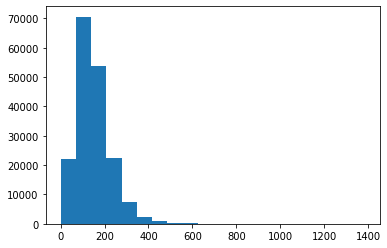

In [65]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [66]:
# Find what characte length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                            output_sequence_length = output_seq_char_len,
                                           # standarize = None, # set standarization to 'None' if you want to leave puntuaction in
                                            name = 'char_vectorizer')

In [71]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [76]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLenght of vectorized chars:\n {len(vectorized_chars[0])}')

Charified text:
 t o   a c h i e v e   b e t w e e n   a   @   %   a n d   @   %   p r o b a b i l i t y   o f   n o   g a g   r e s p o n s e   ,   p r o p o f o l   t c i s   w e r e   b e t w e e n   @   a n d   @   g m l   (   t h a t   c o u l d   b e   a c h i e v e d   w i t h   a   b o l u s   o f   @   m g k g   )   w h e n   r e m i f e n t a n i l   t c i   w a s   f i x e d   a t   @   n g m l   ,   a n d   t a r g e t   p r o p o f o l   t c i s   w e r e   b e t w e e n   @   a n d   @   g m l   (   t h a t   c o u l d   b e   a c h i e v e d   w i t h   a   b o l u s   o f   @   m g k g   )   w h e n   r e m i f e n t a n i l   t c i   w a s   f i x e d   a t   @   n g m l   .

Length of random_train_chars: 268

Vectorized chars:
 [[ 3  7  5 11 13  4  2 21  2 22  2  3 20  2  2  6  5  5  6 10 14  8  7 22
   5 22  4 12  4  3 19  7 17  6  7 18  5 18  8  2  9 14  7  6  9  2 14  8
   7 14  7 17  7 12  3 11  4  9 20  2  8  2 22  2  3 20  2  2  6  5  6 10
  18 15 12  3 13  5  3

## Creating a character-level embedding

In [78]:
# Create character-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25, # Size of the char embedding in the paper
                              mask_zero = True, 
                              name = 'character_embedding')

In [79]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embeddings):\n {char_embed_example}\n')
print(f'Char embedded shape:\n {char_embed_example.shape}')

Charified text:
 t o   a c h i e v e   b e t w e e n   a   @   %   a n d   @   %   p r o b a b i l i t y   o f   n o   g a g   r e s p o n s e   ,   p r o p o f o l   t c i s   w e r e   b e t w e e n   @   a n d   @   g m l   (   t h a t   c o u l d   b e   a c h i e v e d   w i t h   a   b o l u s   o f   @   m g k g   )   w h e n   r e m i f e n t a n i l   t c i   w a s   f i x e d   a t   @   n g m l   ,   a n d   t a r g e t   p r o p o f o l   t c i s   w e r e   b e t w e e n   @   a n d   @   g m l   (   t h a t   c o u l d   b e   a c h i e v e d   w i t h   a   b o l u s   o f   @   m g k g   )   w h e n   r e m i f e n t a n i l   t c i   w a s   f i x e d   a t   @   n g m l   .

Embedded chars (after vectorization and embeddings):
 [[[ 0.03736991  0.03544824  0.0295588  ...  0.0264699   0.0070375
   -0.02411406]
  [-0.01826826 -0.04781715  0.03328884 ...  0.0182214  -0.03101274
    0.01900634]
  [ 0.01375449  0.04624445  0.03747488 ... -0.01748512 -0.03055911
   -0.024844